In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels))
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
#     eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
#                                                                     labels=tf.zeros_like(rates))) # min
#     aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
#                                                                      labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a') # max
    ###################################################### ~Q(s,~a)= r # min
    ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
    targetQs = rewards + (gamma * aQs2_logits)
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 aloss:0.7123 eloss:2.9332 aloss2:0.5064 exploreP:0.9980
Episode:1 meanR:22.5000 R:25.0000 rate:0.0500 aloss:0.7120 eloss:2.8780 aloss2:0.5286 exploreP:0.9956
Episode:2 meanR:23.3333 R:25.0000 rate:0.0500 aloss:0.7114 eloss:2.8316 aloss2:0.5574 exploreP:0.9931
Episode:3 meanR:21.7500 R:17.0000 rate:0.0340 aloss:0.7138 eloss:2.8245 aloss2:0.5576 exploreP:0.9914
Episode:4 meanR:23.4000 R:30.0000 rate:0.0600 aloss:0.6983 eloss:2.7899 aloss2:0.5744 exploreP:0.9885
Episode:5 meanR:24.6667 R:31.0000 rate:0.0620 aloss:0.6995 eloss:2.8707 aloss2:0.5216 exploreP:0.9855
Episode:6 meanR:22.8571 R:12.0000 rate:0.0240 aloss:0.7369 eloss:2.9441 aloss2:0.4761 exploreP:0.9843
Episode:7 meanR:22.2500 R:18.0000 rate:0.0360 aloss:0.7040 eloss:2.8204 aloss2:0.5442 exploreP:0.9825
Episode:8 meanR:21.1111 R:12.0000 rate:0.0240 aloss:0.7023 eloss:2.6731 aloss2:0.6395 exploreP:0.9814
Episode:9 meanR:20.4000 R:14.0000 rate:0.0280 aloss:0.6956 eloss:2.7407 aloss2:0.5

Episode:80 meanR:26.0988 R:22.0000 rate:0.0440 aloss:0.6877 eloss:2.9674 aloss2:0.3384 exploreP:0.8114
Episode:81 meanR:25.9878 R:17.0000 rate:0.0340 aloss:0.7779 eloss:3.1171 aloss2:0.2844 exploreP:0.8100
Episode:82 meanR:25.9398 R:22.0000 rate:0.0440 aloss:0.6877 eloss:2.9562 aloss2:0.3460 exploreP:0.8082
Episode:83 meanR:25.8929 R:22.0000 rate:0.0440 aloss:0.6909 eloss:2.8357 aloss2:0.3869 exploreP:0.8065
Episode:84 meanR:25.8824 R:25.0000 rate:0.0500 aloss:0.7301 eloss:3.0426 aloss2:0.3186 exploreP:0.8045
Episode:85 meanR:25.7907 R:18.0000 rate:0.0360 aloss:0.7087 eloss:2.9576 aloss2:0.3457 exploreP:0.8031
Episode:86 meanR:26.8046 R:114.0000 rate:0.2280 aloss:0.6979 eloss:2.9715 aloss2:0.3393 exploreP:0.7941
Episode:87 meanR:26.7955 R:26.0000 rate:0.0520 aloss:0.6909 eloss:3.0634 aloss2:0.3031 exploreP:0.7920
Episode:88 meanR:26.7191 R:20.0000 rate:0.0400 aloss:0.6958 eloss:2.9120 aloss2:0.3529 exploreP:0.7905
Episode:89 meanR:26.5444 R:11.0000 rate:0.0220 aloss:0.6757 eloss:2.8382

Episode:159 meanR:33.3500 R:19.0000 rate:0.0380 aloss:0.6916 eloss:2.2576 aloss2:0.7337 exploreP:0.6203
Episode:160 meanR:33.2600 R:26.0000 rate:0.0520 aloss:0.6823 eloss:2.2157 aloss2:0.7463 exploreP:0.6187
Episode:161 meanR:33.2500 R:26.0000 rate:0.0520 aloss:0.6841 eloss:2.1978 aloss2:0.7555 exploreP:0.6172
Episode:162 meanR:33.2300 R:22.0000 rate:0.0440 aloss:0.6880 eloss:2.2033 aloss2:0.7511 exploreP:0.6158
Episode:163 meanR:33.1700 R:22.0000 rate:0.0440 aloss:0.6863 eloss:2.1714 aloss2:0.7546 exploreP:0.6145
Episode:164 meanR:33.1200 R:15.0000 rate:0.0300 aloss:0.6902 eloss:2.2036 aloss2:0.7528 exploreP:0.6136
Episode:165 meanR:33.1600 R:31.0000 rate:0.0620 aloss:0.6858 eloss:2.1678 aloss2:0.7697 exploreP:0.6117
Episode:166 meanR:33.2800 R:20.0000 rate:0.0400 aloss:0.6966 eloss:2.1888 aloss2:0.7682 exploreP:0.6105
Episode:167 meanR:33.1900 R:18.0000 rate:0.0360 aloss:0.6902 eloss:2.1801 aloss2:0.7655 exploreP:0.6094
Episode:168 meanR:33.2100 R:22.0000 rate:0.0440 aloss:0.6768 elo

Episode:238 meanR:52.2900 R:16.0000 rate:0.0320 aloss:0.6920 eloss:1.9872 aloss2:1.0091 exploreP:0.3890
Episode:239 meanR:52.3600 R:30.0000 rate:0.0600 aloss:0.6919 eloss:1.9683 aloss2:1.0087 exploreP:0.3879
Episode:240 meanR:52.4800 R:41.0000 rate:0.0820 aloss:0.6978 eloss:1.9679 aloss2:1.0185 exploreP:0.3863
Episode:241 meanR:52.7500 R:46.0000 rate:0.0920 aloss:0.6831 eloss:1.9629 aloss2:1.0217 exploreP:0.3846
Episode:242 meanR:52.7800 R:49.0000 rate:0.0980 aloss:0.6888 eloss:1.9784 aloss2:1.0162 exploreP:0.3828
Episode:243 meanR:52.9700 R:40.0000 rate:0.0800 aloss:0.6836 eloss:1.9368 aloss2:1.0241 exploreP:0.3813
Episode:244 meanR:53.1700 R:36.0000 rate:0.0720 aloss:0.6809 eloss:1.9602 aloss2:1.0122 exploreP:0.3800
Episode:245 meanR:53.2500 R:46.0000 rate:0.0920 aloss:0.6893 eloss:1.9254 aloss2:1.0280 exploreP:0.3783
Episode:246 meanR:53.4800 R:41.0000 rate:0.0820 aloss:0.6899 eloss:1.9408 aloss2:1.0312 exploreP:0.3768
Episode:247 meanR:53.7500 R:47.0000 rate:0.0940 aloss:0.7090 elo

Episode:317 meanR:71.5500 R:58.0000 rate:0.1160 aloss:0.6681 eloss:1.0654 aloss2:2.4928 exploreP:0.2310
Episode:318 meanR:71.9200 R:73.0000 rate:0.1460 aloss:0.6711 eloss:0.7517 aloss2:2.6007 exploreP:0.2294
Episode:319 meanR:72.1900 R:55.0000 rate:0.1100 aloss:0.6680 eloss:0.7335 aloss2:2.6028 exploreP:0.2282
Episode:320 meanR:70.5600 R:27.0000 rate:0.0540 aloss:0.6681 eloss:0.7383 aloss2:2.6349 exploreP:0.2276
Episode:321 meanR:69.3400 R:54.0000 rate:0.1080 aloss:0.6764 eloss:0.9743 aloss2:2.5510 exploreP:0.2265
Episode:322 meanR:67.3200 R:85.0000 rate:0.1700 aloss:0.6774 eloss:0.6318 aloss2:2.6790 exploreP:0.2246
Episode:323 meanR:66.0900 R:46.0000 rate:0.0920 aloss:0.6715 eloss:1.1850 aloss2:2.6737 exploreP:0.2236
Episode:324 meanR:63.1000 R:52.0000 rate:0.1040 aloss:0.6741 eloss:0.9120 aloss2:2.6888 exploreP:0.2225
Episode:325 meanR:63.2100 R:69.0000 rate:0.1380 aloss:0.6818 eloss:1.1962 aloss2:2.6818 exploreP:0.2211
Episode:326 meanR:63.5800 R:96.0000 rate:0.1920 aloss:0.6796 elo

Episode:395 meanR:204.1600 R:170.0000 rate:0.3400 aloss:0.9505 eloss:-3.9486 aloss2:16.7646 exploreP:0.0458
Episode:396 meanR:204.0100 R:153.0000 rate:0.3060 aloss:0.8769 eloss:-4.4866 aloss2:16.9121 exploreP:0.0453
Episode:397 meanR:204.1500 R:158.0000 rate:0.3160 aloss:0.9006 eloss:-3.8959 aloss2:17.0414 exploreP:0.0447
Episode:398 meanR:204.1300 R:108.0000 rate:0.2160 aloss:0.9241 eloss:-3.5438 aloss2:17.0628 exploreP:0.0443
Episode:399 meanR:204.4400 R:158.0000 rate:0.3160 aloss:0.9471 eloss:-3.7345 aloss2:17.0339 exploreP:0.0438
Episode:400 meanR:204.2200 R:152.0000 rate:0.3040 aloss:0.9620 eloss:-3.8172 aloss2:17.0484 exploreP:0.0433
Episode:401 meanR:205.3400 R:146.0000 rate:0.2920 aloss:0.9424 eloss:-3.8734 aloss2:17.1055 exploreP:0.0428
Episode:402 meanR:204.8000 R:148.0000 rate:0.2960 aloss:0.8988 eloss:-4.0846 aloss2:17.1445 exploreP:0.0423
Episode:403 meanR:205.3200 R:166.0000 rate:0.3320 aloss:0.9026 eloss:-3.8220 aloss2:17.2315 exploreP:0.0418
Episode:404 meanR:205.9300 R

Episode:471 meanR:270.0400 R:500.0000 rate:1.0000 aloss:0.8041 eloss:-4.3708 aloss2:20.7774 exploreP:0.0146
Episode:472 meanR:270.0400 R:500.0000 rate:1.0000 aloss:0.7973 eloss:-2.9767 aloss2:20.8204 exploreP:0.0143
Episode:473 meanR:270.0400 R:500.0000 rate:1.0000 aloss:0.7687 eloss:-3.4066 aloss2:20.6948 exploreP:0.0141
Episode:474 meanR:270.0400 R:500.0000 rate:1.0000 aloss:0.7815 eloss:-3.4748 aloss2:20.7159 exploreP:0.0139
Episode:475 meanR:270.0400 R:500.0000 rate:1.0000 aloss:0.7542 eloss:-3.5443 aloss2:20.7689 exploreP:0.0137
Episode:476 meanR:273.3400 R:500.0000 rate:1.0000 aloss:0.7663 eloss:-2.4132 aloss2:20.6461 exploreP:0.0135
Episode:477 meanR:273.3400 R:500.0000 rate:1.0000 aloss:0.7426 eloss:-3.9558 aloss2:20.7151 exploreP:0.0134
Episode:478 meanR:276.1600 R:500.0000 rate:1.0000 aloss:0.7597 eloss:-3.0439 aloss2:20.7455 exploreP:0.0132
Episode:479 meanR:279.2400 R:500.0000 rate:1.0000 aloss:0.7424 eloss:-3.8726 aloss2:20.8456 exploreP:0.0131
Episode:480 meanR:281.9800 R

Episode:548 meanR:400.6000 R:37.0000 rate:0.0740 aloss:0.6570 eloss:-0.4688 aloss2:18.5032 exploreP:0.0103
Episode:549 meanR:395.8200 R:22.0000 rate:0.0440 aloss:0.6578 eloss:5.8623 aloss2:18.4553 exploreP:0.0103
Episode:550 meanR:391.0100 R:19.0000 rate:0.0380 aloss:0.5112 eloss:2.3513 aloss2:18.6159 exploreP:0.0103
Episode:551 meanR:391.0100 R:500.0000 rate:1.0000 aloss:0.6786 eloss:-0.8016 aloss2:18.7197 exploreP:0.0102
Episode:552 meanR:391.0100 R:500.0000 rate:1.0000 aloss:0.7262 eloss:-0.8541 aloss2:18.6124 exploreP:0.0102
Episode:553 meanR:386.1200 R:11.0000 rate:0.0220 aloss:0.6066 eloss:-1.7169 aloss2:19.1945 exploreP:0.0102
Episode:554 meanR:381.2300 R:11.0000 rate:0.0220 aloss:0.6084 eloss:-0.5109 aloss2:19.3174 exploreP:0.0102
Episode:555 meanR:376.3200 R:9.0000 rate:0.0180 aloss:0.6536 eloss:-2.2423 aloss2:18.9787 exploreP:0.0102
Episode:556 meanR:371.4200 R:10.0000 rate:0.0200 aloss:0.6893 eloss:-1.0336 aloss2:18.5900 exploreP:0.0102
Episode:557 meanR:366.6200 R:20.0000 r

Episode:625 meanR:251.5500 R:197.0000 rate:0.3940 aloss:0.4009 eloss:0.9376 aloss2:14.9896 exploreP:0.0100
Episode:626 meanR:248.1900 R:152.0000 rate:0.3040 aloss:0.4396 eloss:1.0790 aloss2:14.8863 exploreP:0.0100
Episode:627 meanR:244.0000 R:81.0000 rate:0.1620 aloss:0.4557 eloss:0.5699 aloss2:15.9475 exploreP:0.0100
Episode:628 meanR:242.3600 R:150.0000 rate:0.3000 aloss:0.4457 eloss:0.7976 aloss2:15.3240 exploreP:0.0100
Episode:629 meanR:243.0100 R:94.0000 rate:0.1880 aloss:0.4048 eloss:1.5890 aloss2:15.0523 exploreP:0.0100
Episode:630 meanR:243.9300 R:102.0000 rate:0.2040 aloss:0.4198 eloss:0.8493 aloss2:14.8941 exploreP:0.0100
Episode:631 meanR:248.8400 R:500.0000 rate:1.0000 aloss:0.4171 eloss:1.1050 aloss2:15.0534 exploreP:0.0100
Episode:632 meanR:249.7900 R:105.0000 rate:0.2100 aloss:0.4090 eloss:2.4583 aloss2:15.0305 exploreP:0.0100
Episode:633 meanR:245.6600 R:87.0000 rate:0.1740 aloss:0.4446 eloss:1.6174 aloss2:15.3203 exploreP:0.0100
Episode:634 meanR:246.7600 R:120.0000 ra

Episode:702 meanR:191.5300 R:177.0000 rate:0.3540 aloss:0.3120 eloss:0.7778 aloss2:12.2493 exploreP:0.0100
Episode:703 meanR:191.3700 R:217.0000 rate:0.4340 aloss:0.3070 eloss:1.5118 aloss2:12.1636 exploreP:0.0100
Episode:704 meanR:190.6100 R:193.0000 rate:0.3860 aloss:0.2947 eloss:1.1483 aloss2:12.0650 exploreP:0.0100
Episode:705 meanR:192.4000 R:400.0000 rate:0.8000 aloss:0.3038 eloss:1.2716 aloss2:12.0372 exploreP:0.0100
Episode:706 meanR:190.9200 R:160.0000 rate:0.3200 aloss:0.3079 eloss:1.3348 aloss2:12.1973 exploreP:0.0100
Episode:707 meanR:190.0200 R:410.0000 rate:0.8200 aloss:0.2965 eloss:1.1425 aloss2:12.1891 exploreP:0.0100
Episode:708 meanR:188.9200 R:173.0000 rate:0.3460 aloss:0.3008 eloss:1.0531 aloss2:12.2681 exploreP:0.0100
Episode:709 meanR:187.2800 R:137.0000 rate:0.2740 aloss:0.3102 eloss:0.7044 aloss2:12.0814 exploreP:0.0100
Episode:710 meanR:187.9700 R:230.0000 rate:0.4600 aloss:0.3005 eloss:0.9348 aloss2:12.1214 exploreP:0.0100
Episode:711 meanR:187.8500 R:315.0000

Episode:779 meanR:361.7200 R:95.0000 rate:0.1900 aloss:0.2283 eloss:1.2917 aloss2:9.2877 exploreP:0.0100
Episode:780 meanR:365.3600 R:500.0000 rate:1.0000 aloss:0.2230 eloss:1.7923 aloss2:8.8445 exploreP:0.0100
Episode:781 meanR:362.0400 R:119.0000 rate:0.2380 aloss:0.2162 eloss:1.8213 aloss2:8.9779 exploreP:0.0100
Episode:782 meanR:364.7300 R:500.0000 rate:1.0000 aloss:0.2306 eloss:1.7801 aloss2:8.8175 exploreP:0.0100
Episode:783 meanR:368.1400 R:500.0000 rate:1.0000 aloss:0.2248 eloss:1.6886 aloss2:8.7565 exploreP:0.0100
Episode:784 meanR:370.2500 R:500.0000 rate:1.0000 aloss:0.2255 eloss:1.6144 aloss2:8.8738 exploreP:0.0100
Episode:785 meanR:368.8500 R:125.0000 rate:0.2500 aloss:0.2290 eloss:1.5402 aloss2:8.8696 exploreP:0.0100
Episode:786 meanR:370.9500 R:500.0000 rate:1.0000 aloss:0.2260 eloss:1.6994 aloss2:8.9195 exploreP:0.0100
Episode:787 meanR:374.2000 R:500.0000 rate:1.0000 aloss:0.2235 eloss:1.5932 aloss2:8.8937 exploreP:0.0100
Episode:788 meanR:377.1800 R:500.0000 rate:1.00

Episode:857 meanR:426.1200 R:116.0000 rate:0.2320 aloss:0.1600 eloss:1.7353 aloss2:7.7237 exploreP:0.0100
Episode:858 meanR:426.1200 R:500.0000 rate:1.0000 aloss:0.1472 eloss:1.6442 aloss2:7.7525 exploreP:0.0100
Episode:859 meanR:426.1200 R:500.0000 rate:1.0000 aloss:0.1412 eloss:1.7090 aloss2:7.6996 exploreP:0.0100
Episode:860 meanR:426.1200 R:500.0000 rate:1.0000 aloss:0.1481 eloss:1.7400 aloss2:7.6560 exploreP:0.0100
Episode:861 meanR:422.3700 R:125.0000 rate:0.2500 aloss:0.1379 eloss:1.5350 aloss2:7.6852 exploreP:0.0100
Episode:862 meanR:422.3700 R:500.0000 rate:1.0000 aloss:0.1382 eloss:1.6833 aloss2:7.5746 exploreP:0.0100
Episode:863 meanR:422.3700 R:500.0000 rate:1.0000 aloss:0.1497 eloss:1.6495 aloss2:7.6356 exploreP:0.0100
Episode:864 meanR:422.3700 R:500.0000 rate:1.0000 aloss:0.1365 eloss:1.6488 aloss2:7.4817 exploreP:0.0100
Episode:865 meanR:422.3700 R:500.0000 rate:1.0000 aloss:0.1405 eloss:1.7897 aloss2:7.5228 exploreP:0.0100
Episode:866 meanR:425.9800 R:500.0000 rate:1.0

Episode:935 meanR:408.3700 R:500.0000 rate:1.0000 aloss:0.1010 eloss:1.8934 aloss2:5.1574 exploreP:0.0100
Episode:936 meanR:406.9900 R:362.0000 rate:0.7240 aloss:0.1038 eloss:1.7903 aloss2:5.1257 exploreP:0.0100
Episode:937 meanR:406.3700 R:438.0000 rate:0.8760 aloss:0.0989 eloss:1.7944 aloss2:5.1453 exploreP:0.0100
Episode:938 meanR:410.4000 R:500.0000 rate:1.0000 aloss:0.1019 eloss:1.8605 aloss2:5.0214 exploreP:0.0100
Episode:939 meanR:407.9000 R:250.0000 rate:0.5000 aloss:0.0978 eloss:1.8690 aloss2:4.9986 exploreP:0.0100
Episode:940 meanR:407.8200 R:160.0000 rate:0.3200 aloss:0.0931 eloss:1.7017 aloss2:4.9140 exploreP:0.0100
Episode:941 meanR:405.7800 R:296.0000 rate:0.5920 aloss:0.0989 eloss:1.8259 aloss2:4.9598 exploreP:0.0100
Episode:942 meanR:407.6300 R:274.0000 rate:0.5480 aloss:0.1021 eloss:1.9094 aloss2:4.8277 exploreP:0.0100
Episode:943 meanR:406.5500 R:392.0000 rate:0.7840 aloss:0.0997 eloss:1.8121 aloss2:4.8298 exploreP:0.0100
Episode:944 meanR:409.5700 R:500.0000 rate:1.0

Episode:1013 meanR:415.7600 R:500.0000 rate:1.0000 aloss:0.0791 eloss:1.8246 aloss2:3.9849 exploreP:0.0100
Episode:1014 meanR:415.7600 R:500.0000 rate:1.0000 aloss:0.0793 eloss:1.8224 aloss2:3.9867 exploreP:0.0100
Episode:1015 meanR:415.7600 R:500.0000 rate:1.0000 aloss:0.0825 eloss:1.8415 aloss2:3.9748 exploreP:0.0100
Episode:1016 meanR:419.7100 R:500.0000 rate:1.0000 aloss:0.0811 eloss:1.8611 aloss2:3.9611 exploreP:0.0100
Episode:1017 meanR:419.7100 R:500.0000 rate:1.0000 aloss:0.0789 eloss:1.8606 aloss2:3.9715 exploreP:0.0100
Episode:1018 meanR:419.7100 R:500.0000 rate:1.0000 aloss:0.0773 eloss:1.8402 aloss2:3.9766 exploreP:0.0100
Episode:1019 meanR:416.1500 R:144.0000 rate:0.2880 aloss:0.0821 eloss:1.7406 aloss2:3.9894 exploreP:0.0100
Episode:1020 meanR:416.1500 R:500.0000 rate:1.0000 aloss:0.0787 eloss:1.8623 aloss2:3.9513 exploreP:0.0100
Episode:1021 meanR:419.2400 R:500.0000 rate:1.0000 aloss:0.0780 eloss:1.8495 aloss2:3.9684 exploreP:0.0100
Episode:1022 meanR:419.2400 R:500.000

Episode:1090 meanR:474.2900 R:500.0000 rate:1.0000 aloss:0.0596 eloss:1.8419 aloss2:3.9446 exploreP:0.0100
Episode:1091 meanR:474.2900 R:500.0000 rate:1.0000 aloss:0.0592 eloss:1.8423 aloss2:3.9464 exploreP:0.0100
Episode:1092 meanR:474.2900 R:500.0000 rate:1.0000 aloss:0.0591 eloss:1.8475 aloss2:3.9676 exploreP:0.0100
Episode:1093 meanR:474.2900 R:500.0000 rate:1.0000 aloss:0.0583 eloss:1.8497 aloss2:3.9620 exploreP:0.0100
Episode:1094 meanR:477.7100 R:500.0000 rate:1.0000 aloss:0.0584 eloss:1.8434 aloss2:3.9562 exploreP:0.0100
Episode:1095 meanR:477.7100 R:500.0000 rate:1.0000 aloss:0.0582 eloss:1.8399 aloss2:3.9655 exploreP:0.0100
Episode:1096 meanR:477.7100 R:500.0000 rate:1.0000 aloss:0.0609 eloss:1.8370 aloss2:3.9527 exploreP:0.0100
Episode:1097 meanR:480.4200 R:500.0000 rate:1.0000 aloss:0.0605 eloss:1.8343 aloss2:3.9617 exploreP:0.0100
Episode:1098 meanR:483.0500 R:500.0000 rate:1.0000 aloss:0.0569 eloss:1.8275 aloss2:3.9541 exploreP:0.0100
Episode:1099 meanR:483.0500 R:500.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

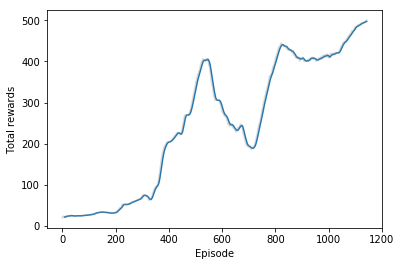

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

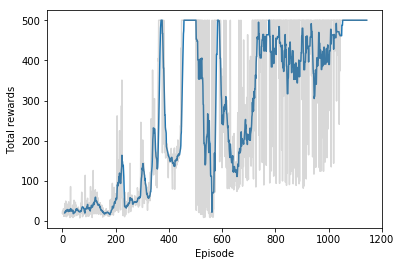

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

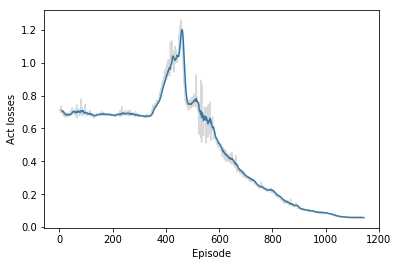

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

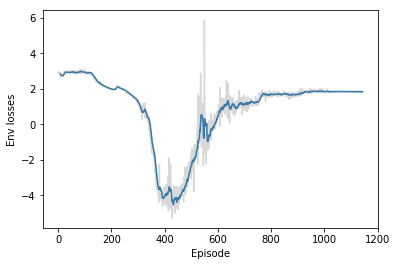

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

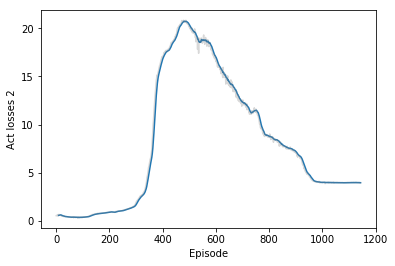

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
